In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding
# 3.2 create mask. (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention
# 4. builds model
# 4.1 MultiheadAttention
# 4.2 EncoderLayer
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Trnasformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

In [3]:
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                          with_info = True,
                          as_supervised = True)
train_examples, val_examples = examples['train'], examples['validation']
print(info)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset ted_hrlr_translate downloaded and prepared to /Users/claire_liu/tensorflow_datasets/ted_hrlr_translate/pt_to_en/0.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machi

In [4]:
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."

b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."

b'agora aqui temos imagens sendo extra\xc3\xaddas em tempo real diretamente do feed ,'
b'now here are live images being pulled straight from the feed .'

b'agora : um , dois , tr\xc3\xaas , vai .'
b'so : one , two , three , go .'

b'eventualmente , vamos ver se teremos todos os sentidos humanos empregues , e se vamos ter meios para viver a hist\xc3\xb3ria qualquer que seja a via escolhida .'
b'eventually , we can see i

In [6]:
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)


In [7]:
sample_string = 'Transformer is awesome'

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('Origin string is {}'.format(origin_string))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799]
Origin string is Transformer is awesome


In [8]:
assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> {}'.format(token, en_tokenizer.decode([token])))

7915 --> T
1248 --> ran
7946 --> s
7194 --> former 
13 --> is 
2799 --> awesome


In [15]:
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    +[en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                         tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                         [pt_sentence, en_sentence],
                         [tf.int64, tf.int64])

train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(batch_size,
                              padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(batch_size,
                                       padded_shapes=([-1], [-1]))



In [16]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 40) (64, 40)
(64, 38) (64, 40)
(64, 40) (64, 40)
(64, 39) (64, 39)
(64, 37) (64, 38)


In [20]:
# PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

# pos.shape: [sentence_length, 1]
# i.shape: [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 *(i // 2)) / np.float(d_model))
    return pos * angle_rates

def get_postion_embedding(sentence_length, d_model):
    angle_rads =  get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_postion_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


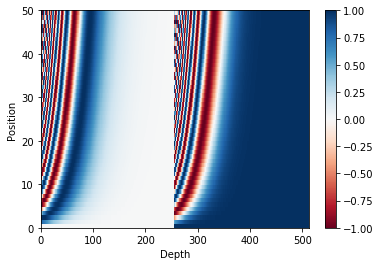

In [21]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim(0, 512)
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

plot_position_embedding(position_embedding)

In [23]:
# 1. padding mask, 2. look ahead

# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=209064, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [30]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

create_look_ahead_mask(3)

<tf.Tensor: id=209120, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [34]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape== (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k = seq_len_v
    - mask shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_ke)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print(temp_att)
    print(temp_out)

In [35]:
temp_k = tf.constant([[10, 0, 0],
                      [0 ,10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)
temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)
temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

tf.Tensor([[8.4332744e-26 1.0000000e+00 8.4332744e-26 8.4332744e-26]], shape=(1, 4), dtype=float32)
tf.Tensor([[1.000000e+01 9.276602e-25]], shape=(1, 2), dtype=float32)


In [36]:
class MultiHeadAttention(keras.layers.Layer):
    """
    q->Wq->Q->split->q0, q1, q2 ...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k , v, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.WQ(q)
        k = self.WK(k)
        v = self.WV(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention_ouputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        concat_attention = tf.reshape(scaled_attention_ouputs, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 256))
output, attn = temp_mha(y, y, y, mask=None)
print(output.shape, attn.shape)


(1, 60, 512) (1, 8, 60, 60)


In [37]:
def feed_forward_network(d_model, dff):
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2018)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [43]:
class EncoderLayer(keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


In [46]:
class DecoderLayer(keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    def call(self, x, encoding_outputs, training, look_ahead_mask, padding_mask):
        attn1, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layer_norm1(attn1 + x)
        
        attn2, attn_weights2 = self.mha2(out1, encoding_outputs, encoding_outputs, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layer_norm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2

sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_weight1, sample_decoder_weight2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape, sample_decoder_weight1.shape, sample_decoder_weight2.shape)
        

(64, 60, 512) (64, 8, 60, 60) (64, 8, 60, 50)


In [47]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length, d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
        self.position_embedding = get_postion_embedding(max_length, self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoding_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)
        ]
        
    def call(self, x, training, mask):
        input_seq_len = tf.shape(x)[1]
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.encoding_layers[i](x, training, mask)
        
        return x

sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input, False, mask=None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


In [51]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length, d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        self.position_embedding = get_postion_embedding(max_length, d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)
        ]
    
    def call(self, x, encoding_outputs, training, look_ahead_mask, padding_mask):
        output_seq_len = tf.shape(x)[1]
        assert output_seq_len <= self.max_length
        
        attention_weights = {}
        
        x = self.embedding(x)
        x *=tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, att1, att2 = self.decoder_layers[i](x, encoding_outputs,
                                                   training, look_ahead_mask,
                                                   padding_mask)
            attention_weights['decoder_layer{}_att1'.format(i+1)] = att1
            attention_weights['decoder_layer{}_att2'.format(i+1)] = att2
        
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)

sampel_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att = sample_decoder_model(sampel_decoder_model_input,
                                                                                sample_encoder_model_output,
                                                                                training=False,
                                                                                look_ahead_mask=None,
                                                                                padding_mask=None)
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [52]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
               max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(num_layers,
                                         input_vocab_size,
                                         max_length,
                                         d_model,
                                         num_heads,
                                         dff,
                                         rate)
        self.decoder_model = DecoderModel(num_layers,
                                         target_vocab_size,
                                         max_length,
                                         d_model,
                                         num_heads,
                                         dff,
                                         rate)
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask, look_ahead_mask, decoder_padding_mask):
        encoding_outputs = self.encoder_model(inp, training, encoder_padding_mask)
        decoding_outputs, attention_weights = self.decoder_model(tar, encoding_outputs,
                                                                 training,
                                                                 look_ahead_mask,
                                                                 decoder_padding_mask)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights

sampel_transformer = Transformer(2, 8500, 800, max_length, 512, 8, 2048, 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sampel_transformer(temp_input, temp_target, training=False,
                                                   encoder_padding_mask=None,
                                                   look_ahead_mask=None,
                                                   decoder_padding_mask=None)
print(predictions.shape)

for key in attention_weights:
    print(key, attention_weights[key].shape)
         

(64, 31, 800)
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)
